
改进上个模型

## 数据处理

1 归一化（Normalization），处理到0~1
    
线性转换 $y=\frac{x-min}{max-min}$

对数 $ y=log_{10}(x)$

反正切 $y=\frac{atan(x)* 2}{\pi}$

2 标准化(Standardization)是将数据按比例缩放，使之落入一个小的特定区间。

(1)z-score标准化，即零-均值标准化（常用方法） $y=\frac{x-\mu}{\sigma}$,是一种统计的处理，基于正态分布的假设，将数据变换为均值为0、标准差为1的标准正态分布。但即使数据不服从正态分布，也可以用此法。特别适用于数据的最大值和最小值未知，或存在孤立点。

(2) 小数定标标准化$y=\frac{x}{10^j}$（j确保max(|y|)<1）,通过移动x的小数位置进行标准化

(3) 对数Logistic模式 $y=\frac{1}{1+e^{-x}}$
        
## 交叉验证

参考

## 学习曲线



In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier


from sklearn.model_selection import cross_val_score

In [2]:
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')
combine = [train_df, test_df]

In [3]:
#分析数据
print(train_df.columns.values)
#features 特征分类
# Categorical分类特征: 分类结果Survived, Sex, and Embarked. cabin
# Ordinal顺序特征: Pclass.
# Continous连续值: Age, Fare.  连续亦有序
# Discrete离散值: SibSp, Parch. name，ticket

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


In [4]:
# preview the data
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
# 信息概要
train_df.info()
print('_'*40)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null

In [6]:
train_df.describe()
#该方法直接查看数据值的分布
# Review survived rate using `percentiles=[.61, .62]` knowing our problem description mentions 38% survival rate.
# Review Parch distribution using `percentiles=[.75, .8]`
# SibSp distribution `[.68, .69]`
# Age and Fare `[.1, .2, .3, .4, .5, .6, .7, .8, .9, .99]`


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


What is the distribution of numerical feature values across the samples?

This helps us determine, among other early insights, how representative is the training dataset of the actual problem domain.

    Total samples are 891 or 40% of the actual number of passengers on board the Titanic (2,224).
    Survived is a categorical feature with 0 or 1 values.
    Around 38% samples survived representative of the actual survival rate at 32%.
    Most passengers (> 75%) did not travel with parents or children.
    Nearly 30% of the passengers had siblings and/or spouse aboard.
    Fares varied significantly with few passengers (<1%) paying as high as $512.
    Few elderly passengers (<1%) within age range 65-80.



In [7]:
train_df.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Najib, Miss. Adele Kiamie ""Jane""",male,347082,B96 B98,S
freq,1,577,7,4,644


In [8]:
pclass=train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)
print(pclass)
#pc高的容易获救

   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363


In [9]:
train_df[['Sex','Survived']].groupby(['Sex'],as_index=False).mean().sort_values(by='Survived',ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [10]:
train_df[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [11]:
print(train_df[["SibSp", "Survived"]].groupby('SibSp').count())
train_df[["SibSp", "Survived"]].groupby('SibSp').mean()

       Survived
SibSp          
0           608
1           209
2            28
3            16
4            18
5             5
8             7


,Survived
SibSp,
0,0.345395
1,0.535885
2,0.464286
3,0.250000
4,0.166667
5,0.000000
8,0.000000


In [12]:
print(train_df[["Parch", "Survived"]].groupby(['Parch'], as_index=False).count())
train_df[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

   Parch  Survived
0      0       678
1      1       118
2      2        80
3      3         5
4      4         4
5      5         5
6      6         1


,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


In [13]:
# grid = sns.FacetGrid(train_df, col='Pclass', hue='Survived')
# grid = sns.FacetGrid(train_df, col='Survived', row='Pclass', size=2.2, aspect=1.6)
# grid.map(plt.hist, 'Age', alpha=.5, bins=20)
# grid.add_legend();

In [14]:
print("Before", train_df.shape, test_df.shape, combine[0].shape, combine[1].shape)

train_df = train_df.drop(['Ticket', 'Cabin'], axis=1)
test_df = test_df.drop(['Ticket', 'Cabin'], axis=1)
combine = [train_df, test_df]

"After", train_df.shape, test_df.shape, combine[0].shape, combine[1].shape

Before (891, 12) (418, 11) (891, 12) (418, 11)


('After', (891, 10), (418, 9), (891, 10), (418, 9))

In [15]:
#视图抽取title
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(train_df['Title'], train_df['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [16]:
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

print(train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).count())
train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

    Title  Survived
0  Master        40
1    Miss       185
2      Mr       517
3     Mrs       126
4    Rare        23


,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


In [17]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,Mr


In [18]:
#本次放弃将title数值化
# title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
# for dataset in combine:
#     dataset['Title'] = dataset['Title'].map(title_mapping)
#     dataset['Title'] = dataset['Title'].fillna(0)

# train_df.head()

In [19]:
#去除name，name的关联性直觉上不大
train_df = train_df.drop(['Name', 'PassengerId'], axis=1)
test_df = test_df.drop(['Name'], axis=1)
combine = [train_df, test_df]
train_df.shape, test_df.shape

((891, 9), (418, 9))

In [20]:
# train_df = train_df.drop(['sp'], axis=1)
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,male,22.0,1,0,7.2500,S,Mr
1,1,1,female,38.0,1,0,71.2833,C,Mrs
2,1,3,female,26.0,0,0,7.9250,S,Miss
3,1,1,female,35.0,1,0,53.1000,S,Mrs
4,0,3,male,35.0,0,0,8.0500,S,Mr


In [21]:
#不进行sex数值化
for dataset in combine:
    dataset['Sex_number'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Sex_number
0,0,3,male,22.0,1,0,7.2500,S,Mr,0
1,1,1,female,38.0,1,0,71.2833,C,Mrs,1
2,1,3,female,26.0,0,0,7.9250,S,Miss,1
3,1,1,female,35.0,1,0,53.1000,S,Mrs,1
4,0,3,male,35.0,0,0,8.0500,S,Mr,0


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


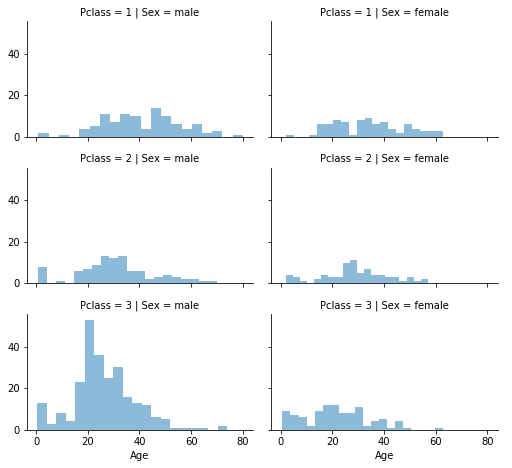

In [22]:
# grid = sns.FacetGrid(train_df, col='Pclass', hue='Gender')
grid = sns.FacetGrid(train_df, row='Pclass', col='Sex', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()

In [23]:
#根据经验猜年龄
guess_ages = np.zeros((2,3))
guess_ages
#         pclass1 2 3
# male
# female

array([[0., 0., 0.],
       [0., 0., 0.]])

In [24]:
sexDict={'male':0,'female':1}
for dataset in combine:
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[(dataset['Sex_number'] == i) & (dataset['Pclass'] == j+1)]['Age'].dropna()
            # age_mean = guess_df.mean()
            # age_std = guess_df.std()
            # age_guess = rnd.uniform(age_mean - age_std, age_mean + age_std)

            age_guess = guess_df.median()
            # Convert random age float to nearest .5 age
            guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5
            
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex_number == i) & (dataset.Pclass == j+1),\
                    'Age'] = guess_ages[i,j]

    dataset['Age'] = dataset['Age'].astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Sex_number
0,0,3,male,22,1,0,7.2500,S,Mr,0
1,1,1,female,38,1,0,71.2833,C,Mrs,1
2,1,3,female,26,0,0,7.9250,S,Miss,1
3,1,1,female,35,1,0,53.1000,S,Mrs,1
4,0,3,male,35,0,0,8.0500,S,Mr,0


In [25]:
train_df=train_df.drop(['Sex_number'],axis=1)
test_df=test_df.drop(['Sex_number'],axis=1)

In [26]:
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,male,22,1,0,7.2500,S,Mr
1,1,1,female,38,1,0,71.2833,C,Mrs
2,1,3,female,26,0,0,7.9250,S,Miss
3,1,1,female,35,1,0,53.1000,S,Mrs
4,0,3,male,35,0,0,8.0500,S,Mr


In [27]:
#可见，需要对数据有更多的理解，才能确定哪些特征是有用的
# train_df['AgeBand'] = pd.cut(train_df['Age'], 5)
# train_df[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

In [28]:
# for dataset in combine:    
#     dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
#     dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
#     dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
#     dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
#     dataset.loc[ dataset['Age'] > 64, 'Age']
# train_df.head()

In [29]:
# train_df = train_df.drop(['AgeBand'], axis=1)
# combine = [train_df, test_df]
# train_df.head()

In [30]:
train_df['FamilySize'] = train_df['SibSp'] + dataset['Parch'] + 1
test_df['FamilySize'] = test_df['SibSp'] + dataset['Parch'] + 1
train_df.head()
# train_df[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,FamilySize
0,0,3,male,22,1,0,7.2500,S,Mr,2.0
1,1,1,female,38,1,0,71.2833,C,Mrs,2.0
2,1,3,female,26,0,0,7.9250,S,Miss,1.0
3,1,1,female,35,1,0,53.1000,S,Mrs,2.0
4,0,3,male,35,0,0,8.0500,S,Mr,2.0


In [31]:
print(train_df[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).count())
train_df[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

   FamilySize  Survived
0         1.0       221
1         2.0       106
2         3.0        39
3         4.0        21
4         5.0        17
5         6.0         5
6         7.0         3
7         9.0         2
8        10.0         2
9        11.0         2


,FamilySize,Survived
1,2.0,0.509434
0,1.0,0.384615
2,3.0,0.358974
4,5.0,0.294118
3,4.0,0.238095
5,6.0,0.000000
6,7.0,0.000000
7,9.0,0.000000
8,10.0,0.000000
9,11.0,0.000000


In [33]:
train_df.loc[0]

Survived         0
Pclass           3
Sex           male
Age             22
SibSp            1
Parch            0
Fare          7.25
Embarked         S
Title           Mr
FamilySize       2
Name: 0, dtype: object

In [34]:
#is alone
train_df['IsAlone'] = 0
train_df.loc[train_df['FamilySize'] == 1, 'IsAlone'] = 1
test_df['IsAlone'] = 0
test_df.loc[test_df['FamilySize'] == 1, 'IsAlone'] = 1
train_df.head()
# train_df[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,FamilySize,IsAlone
0,0,3,male,22,1,0,7.2500,S,Mr,2.0,0
1,1,1,female,38,1,0,71.2833,C,Mrs,2.0,0
2,1,3,female,26,0,0,7.9250,S,Miss,1.0,1
3,1,1,female,35,1,0,53.1000,S,Mrs,2.0,0
4,0,3,male,35,0,0,8.0500,S,Mr,2.0,0


In [35]:
print(train_df[["IsAlone", "Survived"]].groupby(['IsAlone'], as_index=False).count())
train_df[["IsAlone", "Survived"]].groupby(['IsAlone'], as_index=False).mean().sort_values(by='Survived', ascending=False)

   IsAlone  Survived
0        0       670
1        1       221


,IsAlone,Survived
1,1,0.384615
0,0,0.383582


In [36]:
train_df[["FamilySize", "Survived"]].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
1,2.0,0.509434
0,1.0,0.384615
2,3.0,0.358974
4,5.0,0.294118
3,4.0,0.238095
5,6.0,0.000000
6,7.0,0.000000
7,9.0,0.000000
8,10.0,0.000000
9,11.0,0.000000


In [37]:
train_df = train_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
test_df = test_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
combine = [train_df, test_df]

train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,0,3,male,22,7.2500,S,Mr,0
1,1,1,female,38,71.2833,C,Mrs,0
2,1,3,female,26,7.9250,S,Miss,1
3,1,1,female,35,53.1000,S,Mrs,0
4,0,3,male,35,8.0500,S,Mr,0


In [38]:
for dataset in combine:
    dataset['Age*Class'] = dataset.Age//10 * dataset.Pclass   
train_df.loc[:, ['Age*Class', 'Age', 'Pclass']].head(10)

,Age*Class,Age,Pclass
0,6,22,3
1,3,38,1
2,6,26,3
3,3,35,1
4,9,35,3
5,6,25,3
6,5,54,1
7,0,2,3
8,6,27,3
9,2,14,2


In [39]:
train_df[['Age*Class', 'Survived']].groupby(['Age*Class'], as_index=False).mean()

,Age*Class,Survived
0,0,0.612903
1,1,0.833333
2,2,0.634615
3,3,0.520000
4,4,0.451327
5,5,0.555556
6,6,0.265487
7,7,0.000000
8,8,0.578947
9,9,0.217391


In [40]:
train_df[['Age*Class', 'Survived']].groupby(['Age*Class'], as_index=False).mean()

,Age*Class,Survived
0,0,0.612903
1,1,0.833333
2,2,0.634615
3,3,0.520000
4,4,0.451327
5,5,0.555556
6,6,0.265487
7,7,0.000000
8,8,0.578947
9,9,0.217391


In [41]:
freq_port = train_df.Embarked.dropna().mode()[0]
freq_port

'S'

In [42]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)
    
train_df[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


In [43]:
# for dataset in combine:
#     dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,0,3,male,22,7.2500,S,Mr,0,6
1,1,1,female,38,71.2833,C,Mrs,0,3
2,1,3,female,26,7.9250,S,Miss,1,6
3,1,1,female,35,53.1000,S,Mrs,0,3
4,0,3,male,35,8.0500,S,Mr,0,9


In [44]:
test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)
test_df.head()
train_df.describe()

,Survived,Pclass,Age,Fare,IsAlone,Age*Class
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.072952,32.204208,0.248036,5.281706
std,0.486592,0.836071,13.326339,49.693429,0.432115,3.065262
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,21.000000,7.910400,0.000000,3.000000
50%,0.000000,3.000000,26.000000,14.454200,0.000000,6.000000
75%,1.000000,3.000000,36.000000,31.000000,0.000000,6.000000
max,1.000000,3.000000,80.000000,512.329200,1.000000,21.000000


In [45]:
# train_df=train_df.drop(['sp'],axis=1)
train_df.head(10)

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,0,3,male,22,7.2500,S,Mr,0,6
1,1,1,female,38,71.2833,C,Mrs,0,3
2,1,3,female,26,7.9250,S,Miss,1,6
3,1,1,female,35,53.1000,S,Mrs,0,3
4,0,3,male,35,8.0500,S,Mr,0,9
5,0,3,male,25,8.4583,Q,Mr,1,6
6,0,1,male,54,51.8625,S,Mr,1,5
7,0,3,male,2,21.0750,S,Master,0,0
8,1,3,female,27,11.1333,S,Mrs,1,6
9,1,2,female,14,30.0708,C,Mrs,0,2


In [46]:
print(train_df[["Age*Class","Survived"]].groupby(["Age*Class"]).count())
train_df[["Age*Class","Survived"]].groupby(["Age*Class"]).mean().sort_values(by='Survived', ascending=False)

           Survived
Age*Class          
0                62
1                18
2                52
3               125
4               113
5                27
6               339
7                 3
8                19
9                69
10               15
12               37
14                1
15                6
18                3
21                2


,Survived
Age*Class,
1,0.833333
2,0.634615
0,0.612903
8,0.578947
5,0.555556
3,0.520000
4,0.451327
10,0.333333
18,0.333333


In [47]:
# train_df=train_df.drop(["Age*Class"],axis=1)
# test_df=test_df.drop(["Age*Class"],axis=1)
# test_df.head()

In [48]:

train_df=train_df.fillna(0)
test_df=test_df.fillna(0)
train_df.info()

test_df=test_df.drop(["Age*Class"],axis=1)
train_df=train_df.drop(["Age*Class"],axis=1)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
Survived     891 non-null int64
Pclass       891 non-null int64
Sex          891 non-null object
Age          891 non-null int32
Fare         891 non-null float64
Embarked     891 non-null object
Title        891 non-null object
IsAlone      891 non-null int64
Age*Class    891 non-null int64
dtypes: float64(1), int32(1), int64(4), object(3)
memory usage: 59.2+ KB


In [49]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Sex            418 non-null object
Age            418 non-null int32
Fare           418 non-null float64
Embarked       418 non-null object
Title          418 non-null object
IsAlone        418 non-null int64
dtypes: float64(1), int32(1), int64(3), object(3)
memory usage: 24.6+ KB


In [50]:
##hot encode
#独热编码
from sklearn.feature_extraction import DictVectorizer
vec = DictVectorizer(sparse=False, dtype=int)
trainn=vec.fit_transform(train_df.T.to_dict().values())
train_df2 =pd.DataFrame(trainn,columns=vec.feature_names_)
print(vec.feature_names_)
print(train_df2.shape)

vec2 = DictVectorizer(sparse=False, dtype=int)
testt=vec2.fit_transform(test_df.T.to_dict().values())
test_df2 =pd.DataFrame(testt,columns=vec2.feature_names_)
print(vec2.feature_names_,test_df2.shape)

['Age', 'Embarked=C', 'Embarked=Q', 'Embarked=S', 'Fare', 'IsAlone', 'Pclass', 'Sex=female', 'Sex=male', 'Survived', 'Title=Master', 'Title=Miss', 'Title=Mr', 'Title=Mrs', 'Title=Rare']
(891, 15)
['Age', 'Embarked=C', 'Embarked=Q', 'Embarked=S', 'Fare', 'IsAlone', 'PassengerId', 'Pclass', 'Sex=female', 'Sex=male', 'Title=Master', 'Title=Miss', 'Title=Mr', 'Title=Mrs', 'Title=Rare'] (418, 15)


In [51]:
test_df2.shape
train_df2.columns

Index(['Age', 'Embarked=C', 'Embarked=Q', 'Embarked=S', 'Fare', 'IsAlone',
       'Pclass', 'Sex=female', 'Sex=male', 'Survived', 'Title=Master',
       'Title=Miss', 'Title=Mr', 'Title=Mrs', 'Title=Rare'],
      dtype='object')

In [52]:
X_train = train_df2.drop(["Survived"], axis=1)
Y_train = train_df2["Survived"]
# X_train = train_df2["Survived","Embarked"]
X_test  = test_df2.drop("PassengerId", axis=1).copy()
X_train.shape, Y_train.shape, X_test.shape

((891, 14), (891,), (418, 14))

In [53]:
from sklearn.preprocessing import StandardScaler
trainstd=StandardScaler()
xtrain=pd.DataFrame(trainstd.fit_transform(X_train),columns = X_train.columns)
xtrain.head()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int32 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int32 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,Age,Embarked=C,Embarked=Q,Embarked=S,Fare,IsAlone,Pclass,Sex=female,Sex=male,Title=Master,Title=Miss,Title=Mr,Title=Mrs,Title=Rare
0,-0.531048,-0.482043,-0.307562,0.615838,-0.498948,-0.574326,0.827377,-0.737695,0.737695,-0.216803,-0.511898,0.850532,-0.405840,-0.162781
1,0.670256,2.074505,-0.307562,-1.623803,0.789405,-0.574326,-1.566107,1.355574,-1.355574,-0.216803,-0.511898,-1.175735,2.464027,-0.162781
2,-0.230722,-0.482043,-0.307562,0.615838,-0.498948,1.741170,0.827377,1.355574,-1.355574,-0.216803,1.953514,-1.175735,-0.405840,-0.162781
3,0.445012,-0.482043,-0.307562,0.615838,0.427056,-0.574326,-1.566107,1.355574,-1.355574,-0.216803,-0.511898,-1.175735,2.464027,-0.162781
4,0.445012,-0.482043,-0.307562,0.615838,-0.478817,-0.574326,0.827377,-0.737695,0.737695,-0.216803,-0.511898,0.850532,-0.405840,-0.162781


In [54]:
teststd=StandardScaler()
xtest=pd.DataFrame(teststd.fit_transform(X_test),columns = X_test.columns)
xtest.head()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int32 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int32 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,Age,Embarked=C,Embarked=Q,Embarked=S,Fare,IsAlone,Pclass,Sex=female,Sex=male,Title=Master,Title=Miss,Title=Mr,Title=Mrs,Title=Rare
0,0.362522,-0.568142,2.843757,-1.350676,-0.504292,0.807573,0.873482,-0.755929,0.755929,-0.229993,-0.48274,0.861201,-0.456172,-0.120678
1,1.359458,-0.568142,-0.351647,0.740370,-0.504292,-1.238278,0.873482,1.322876,-1.322876,-0.229993,-0.48274,-1.161169,2.192158,-0.120678
2,2.509769,-0.568142,2.843757,-1.350676,-0.468443,0.807573,-0.315819,-0.755929,0.755929,-0.229993,-0.48274,0.861201,-0.456172,-0.120678
3,-0.174289,-0.568142,-0.351647,0.740370,-0.486368,0.807573,0.873482,-0.755929,0.755929,-0.229993,-0.48274,0.861201,-0.456172,-0.120678
4,-0.557726,-0.568142,-0.351647,0.740370,-0.414669,-1.238278,0.873482,1.322876,-1.322876,-0.229993,-0.48274,-1.161169,2.192158,-0.120678


In [55]:
# Logistic Regression
logreg = LogisticRegression(solver='liblinear')
logreg.fit(xtrain, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(xtrain, Y_train) * 100, 2)
print('self',acc_log)
score_line=cross_val_score(logreg, xtrain, Y_train, cv=10)
print(score_line.mean())

self 81.82
0.8036409034161842


In [56]:
coeff_df = pd.DataFrame(train_df2.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
7,Sex=male,0.652566
9,Title=Master,0.398688
5,Pclass,0.117963
1,Embarked=Q,0.107328
12,Title=Mrs,0.087947
2,Embarked=S,0.057812
4,IsAlone,-0.042914
13,Title=Rare,-0.047979
11,Title=Mr,-0.100908
3,Fare,-0.130405


In [57]:
# Support Vector Machines
svc = SVC(gamma='auto')
svc.fit(xtrain, Y_train)
Y_pred_svc = svc.predict(xtest)
acc_svc001 = round(svc.score(xtrain, Y_train) * 100, 2)
print('self',acc_svc001)
score_svc=cross_val_score(svc, xtrain, Y_train, cv=10)
print(score_svc,'\n', score_svc.mean())

self 83.84
[0.77777778 0.8        0.78651685 0.87640449 0.87640449 0.80898876
 0.79775281 0.75280899 0.80898876 0.84090909] 
 0.8126552037226196


In [58]:
# Support Vector Machines
svc2 = SVC(C=50,gamma='scale')
svc2.fit(xtrain, Y_train)
Y_pred_svc2 = svc.predict(X_test)
acc_svc002 = round(svc2.score(xtrain, Y_train) * 100, 2)
print('self',acc_svc002)
score_svc2=cross_val_score(svc2, xtrain, Y_train, cv=10)
print(score_svc2,'\n', score_svc2.mean())

self 85.86
[0.78888889 0.81111111 0.76404494 0.84269663 0.83146067 0.79775281
 0.80898876 0.76404494 0.84269663 0.85227273] 
 0.8103958120531154


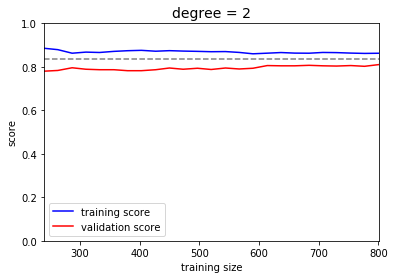

In [59]:
    from sklearn.model_selection import learning_curve
    N, train_lc, val_lc = learning_curve(svc2,
                                         xtrain, Y_train, cv=10
                                         ,train_sizes=np.linspace(0.3, 1, 25)
                                        )
    
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(N, np.mean(train_lc, 1), color='blue', label='training score')
    ax.plot(N, np.mean(val_lc, 1), color='red', label='validation score')
    ax.hlines(np.mean([train_lc[-1], val_lc[-1]]), N[0], N[-1],
                 color='gray', linestyle='dashed')

    ax.set_ylim(0, 1)
    ax.set_xlim(N[0], N[-1])
    ax.set_xlabel('training size')
    ax.set_ylabel('score')
    ax.set_title('degree = {0}'.format(2), size=14)
    ax.legend(loc='best')

In [60]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

#pca降维
pca = PCA(n_components=9, whiten=True, random_state=42)
svc3 = SVC(kernel='rbf', class_weight='balanced',gamma='auto')
model = make_pipeline(pca, svc3)
model.fit(xtrain, Y_train)
Y_pred_pipe = model.predict(X_test)
acc_svcp = round(model.score(xtrain, Y_train) * 100, 2)
print('self',acc_svcp)

score_svc3=cross_val_score(svc3, xtrain, Y_train, cv=10)
print(score_svc3,'\n', score_svc3.mean())

self 80.47
[0.78888889 0.8        0.78651685 0.88764045 0.79775281 0.78651685
 0.78651685 0.74157303 0.84269663 0.78409091] 
 0.8002193281125866


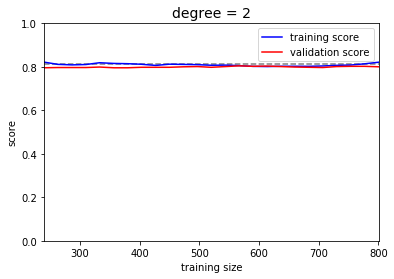

In [61]:
    N, train_lc, val_lc = learning_curve(svc3,
                                         xtrain, Y_train, cv=10
                                         ,train_sizes=np.linspace(0.3, 1, 25)
                                        )
    
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(N, np.mean(train_lc, 1), color='blue', label='training score')
    ax.plot(N, np.mean(val_lc, 1), color='red', label='validation score')
    ax.hlines(np.mean([train_lc[-1], val_lc[-1]]), N[0], N[-1],
                 color='gray', linestyle='dashed')

    ax.set_ylim(0, 1)
    ax.set_xlim(N[0], N[-1])
    ax.set_xlabel('training size')
    ax.set_ylabel('score')
    ax.set_title('degree = {0}'.format(2), size=14)
    ax.legend(loc='best')

In [62]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(xtrain, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(xtrain, Y_train) * 100, 2)
print(acc_knn)

score_knn=cross_val_score(knn, xtrain, Y_train, cv=10)
print(score_knn,'\n', score_knn.mean())

88.33
[0.75555556 0.77777778 0.7752809  0.84269663 0.86516854 0.82022472
 0.85393258 0.78651685 0.80898876 0.81818182] 
 0.8104324140279197


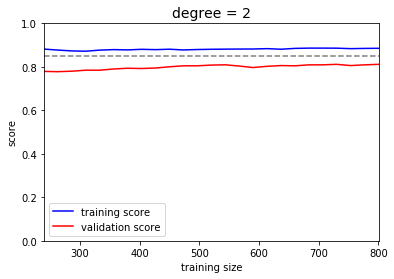

In [63]:
    N, train_lc, val_lc = learning_curve(knn,
                                         xtrain, Y_train, cv=10
                                         ,train_sizes=np.linspace(0.3, 1, 25)
                                        )
    
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(N, np.mean(train_lc, 1), color='blue', label='training score')
    ax.plot(N, np.mean(val_lc, 1), color='red', label='validation score')
    ax.hlines(np.mean([train_lc[-1], val_lc[-1]]), N[0], N[-1],
                 color='gray', linestyle='dashed')

    ax.set_ylim(0, 1)
    ax.set_xlim(N[0], N[-1])
    ax.set_xlabel('training size')
    ax.set_ylabel('score')
    ax.set_title('degree = {0}'.format(2), size=14)
    ax.legend(loc='best')

In [64]:
# Gaussian Naive Bayes
gaussian = GaussianNB()
gaussian.fit(xtrain, Y_train)
acc_gs = round(gaussian.score(xtrain, Y_train) * 100, 2)
print(acc_gs)
score_knn=cross_val_score(knn, xtrain, Y_train, cv=10)
print(score_knn,'\n', score_knn.mean())

78.68
[0.75555556 0.77777778 0.7752809  0.84269663 0.86516854 0.82022472
 0.85393258 0.78651685 0.80898876 0.81818182] 
 0.8104324140279197


In [65]:
# Perceptron
perceptron = Perceptron()
perceptron.fit(xtrain, Y_train)
Y_pred = perceptron.predict(xtest)
acc_perceptron = round(perceptron.score(xtrain, Y_train) * 100, 2)
acc_perceptron

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in Perceptron in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


78.68

In [66]:
# Linear SVC
linear_svc = LinearSVC()
score_lv=cross_val_score(linear_svc, xtrain, Y_train, cv=10)
print(score_lv,'\n', score_lv.mean())

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

[0.76666667 0.81111111 0.76404494 0.84269663 0.78651685 0.79775281
 0.78651685 0.74157303 0.82022472 0.81818182] 
 0.7935285438656224


In [67]:
# Stochastic Gradient Descent
sgd = SGDClassifier()
sgd.fit(xtrain, Y_train)
Y_pred = sgd.predict(X_test)
acc_sgd = round(sgd.score(xtrain, Y_train) * 100, 2)
print(acc_sgd)

from sklearn.model_selection import cross_val_score
score_sgd=cross_val_score(sgd, xtrain, Y_train, cv=10)
print(score_sgd,'\n', score_sgd.mean())

76.32
[0.57777778 0.78888889 0.71910112 0.68539326 0.75280899 0.78651685
 0.76404494 0.65168539 0.61797753 0.72727273] 
 0.7071467483827034


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=

In [68]:
# Decision Tree
decision_tree = DecisionTreeClassifier()
decision_tree.fit(xtrain, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(xtrain, Y_train) * 100, 2)
print(acc_decision_tree)

from sklearn.model_selection import cross_val_score
score_dt=cross_val_score(decision_tree, xtrain, Y_train, cv=10)
print(score_dt,'\n', score_dt.mean())

97.08
[0.73333333 0.75555556 0.75280899 0.86516854 0.85393258 0.79775281
 0.82022472 0.78651685 0.7752809  0.80681818] 
 0.7947392463965498


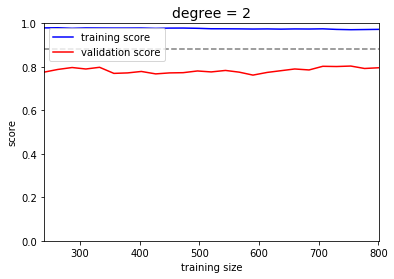

In [69]:
    N, train_lc, val_lc = learning_curve(decision_tree,
                                         xtrain, Y_train, cv=10
                                         ,train_sizes=np.linspace(0.3, 1, 25)
                                        )
    
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(N, np.mean(train_lc, 1), color='blue', label='training score')
    ax.plot(N, np.mean(val_lc, 1), color='red', label='validation score')
    ax.hlines(np.mean([train_lc[-1], val_lc[-1]]), N[0], N[-1],
                 color='gray', linestyle='dashed')

    ax.set_ylim(0, 1)
    ax.set_xlim(N[0], N[-1])
    ax.set_xlabel('training size')
    ax.set_ylabel('score')
    ax.set_title('degree = {0}'.format(2), size=14)
    ax.legend(loc='best')

In [70]:
# Random Forest
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(xtrain, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(xtrain, Y_train)
acc_random_forest = round(random_forest.score(xtrain, Y_train) * 100, 2)
print('self',acc_random_forest)

score_tree=cross_val_score(random_forest, xtrain, Y_train, cv=10)
print(score_tree,'\n', score_tree.mean())

self 97.08
[0.8        0.81111111 0.7752809  0.79775281 0.83146067 0.82022472
 0.83146067 0.76404494 0.78651685 0.82954545] 
 0.8047398138690273


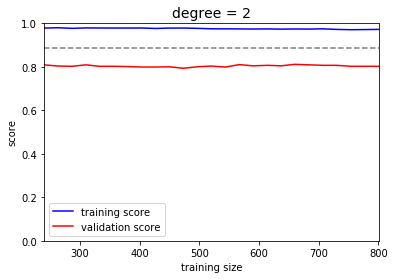

In [71]:
    N, train_lc, val_lc = learning_curve(random_forest,
                                         xtrain, Y_train, cv=10
                                         ,train_sizes=np.linspace(0.3, 1, 25)
                                        )
    
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(N, np.mean(train_lc, 1), color='blue', label='training score')
    ax.plot(N, np.mean(val_lc, 1), color='red', label='validation score')
    ax.hlines(np.mean([train_lc[-1], val_lc[-1]]), N[0], N[-1],
                 color='gray', linestyle='dashed')

    ax.set_ylim(0, 1)
    ax.set_xlim(N[0], N[-1])
    ax.set_xlabel('training size')
    ax.set_ylabel('score')
    ax.set_title('degree = {0}'.format(2), size=14)
    ax.legend(loc='best')

In [72]:
from sklearn.ensemble import GradientBoostingClassifier

In [73]:
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_pred_svc
    })
submission.to_csv('./submission_svc_04202.csv', index=False)

In [74]:
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from xgboost import plot_importance

In [75]:
# # 拟合XGBoost模型
# model = XGBClassifier()
# model.fit(xtrain, Y_train)
 
# # 对测试集做预测
# y_pred = model.predict(X_test)
# # predictions = [round(value) for value in y_pred]？
 
# # 评估预测结果

# acc_decision_tree = round(model.score(xtrain, Y_train) * 100, 2)
# print(acc_decision_tree)
# # accuracy = accuracy_score(y_test, predictions)
# # print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [76]:
model = XGBClassifier(learning_rate=0.1,
                        n_estimators=100,         # 树的个数--1000棵树建立xgboost
                        max_depth=6,               # 树的深度
                        min_child_weight = 1,      # 叶子节点最小权重
                        gamma=0.,                  # 惩罚项中叶子结点个数前的参数
                        subsample=0.8,             # 随机选择80%样本建立决策树
                        colsample_btree=0.8,       # 随机选择80%特征建立决策树
                        objective='multi:softmax', # 指定损失函数
                        scale_pos_weight=1,        # 解决样本个数不平衡的问题
                        random_state=27            # 随机数
                        )

In [78]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
xgb_param = model.get_xgb_params()
extra = {'num_class': 3}
xgb_param.update(extra)
model.set_params(xgb_param)
model.fit(xtrain, Y_train)
# Model is an XGBClassifier
Y_pred = model.predict(X_test)
model.score(xtrain, Y_train)
accmodel = round(model.score(xtrain, Y_train) * 100, 2)
print('self',accmodel)

score_xg=cross_val_score(model, xtrain, Y_train, cv=10)
print(score_xg,'\n', score_xg.mean())

TypeError: set_params() takes 1 positional argument but 2 were given